In [223]:
import collections
import sys
import os
import re
import time
import numpy as np
import pandas as pd

In [224]:
class StubLogger(object):
    def __getattr__(self, name):
        return self.log_print

    def log_print(self, msg, *args):
        print(msg % args)

LOGGER = StubLogger()
LOGGER.info("Hello %s!", "world")

Hello world!


In [225]:
import contextlib
import time

@contextlib.contextmanager
def elapsed_timer(message):
    start_time = time.time()
    yield
    LOGGER.info(message.format(time.time() - start_time))

# Evaluation mechanism

Evaluation Functions

In [226]:
def hitsAtK(user_ranks, k=10):
    return (user_ranks["rank"].notna() & (user_ranks["rank"] <= k)).sum(skipna=True)


def precisionAtK(user_ranks, k):
    precision = float(hitsAtK(user_ranks, k)) / k
    return precision


def recallAtK(user_ranks, k):
    recall = float(hitsAtK(user_ranks, k)) / user_ranks.shape[0]
    return recall


def averagePrecisionAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_correct_user_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]

    if k_correct_user_ranks.shape[0] > 0:
        #print k_correct_user_ranks
        score = 0.0
        for row in range(k_correct_user_ranks.shape[0]):
            tmp_user_ranks = k_correct_user_ranks.head(row + 1)
            row_k = k_correct_user_ranks.iloc[row]["rank"]
            score = score + precisionAtK(tmp_user_ranks, row_k)
        avgPrec = float(score) / min(user_ranks.shape[0], k)
    else:
        avgPrec = 0.0
    return avgPrec


def ndcgAtK(user_ranks, k):
    def dcg(rank):
        return 1.0 / np.log2(rank + 1)


    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]["rank"].values

    ranks_idcg = dcg(np.arange(1, k_user_ranks.shape[0] + 1))
    ranks_dcg = dcg(k_ranks)

    ndcg = float(np.sum(ranks_dcg)) / np.sum(ranks_idcg)
    return ndcg


def topEventsAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    return pd.DataFrame({
        "event_id": k_user_ranks["event_id"].drop_duplicates().sort_values()
    })

In [227]:
def quickMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
    })


def basicMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
    })


def quadMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_50": [precisionAtK(user_ranks, 50)],
        "precision_at_20": [precisionAtK(user_ranks, 20)],
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "precision_at_5": [precisionAtK(user_ranks, 5)],
        "recall_at_50": [recallAtK(user_ranks, 50)],
        "recall_at_20": [recallAtK(user_ranks, 20)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "recall_at_5": [recallAtK(user_ranks, 5)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "ndcg_at_5": [ndcgAtK(user_ranks, 5)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
        "avg_prec_at_5": [averagePrecisionAtK(user_ranks, 5)],
    })

In [228]:
def evalMetrics(rank_data, *, runMetricsPerUser=None):
    if runMetricsPerUser is None:
        runMetricsPerUser = quadMetricsPerUser

    user_metrics = rank_data.groupby("user_id").apply(runMetricsPerUser)
    top_events_at_10 = rank_data.groupby("user_id").apply(topEventsAtK, 10)
    top_events_at_20 = rank_data.groupby("user_id").apply(topEventsAtK, 20)

    metrics = dict()
    # Precision
    if "precision_at_50" in user_metrics.columns:
        precision_50 = user_metrics["precision_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_50"] = [precision_50]
    if "precision_at_20" in user_metrics.columns:
        precision_20 = user_metrics["precision_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_20"] = [precision_20]
    if "precision_at_10" in user_metrics.columns:
        precision_10 = user_metrics["precision_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_10"] = [precision_10]
    if "precision_at_5" in user_metrics.columns:
        precision_5 = user_metrics["precision_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_5"] = [precision_5]

    # Recall
    if "recall_at_50" in user_metrics.columns:
        recall_50 = user_metrics["recall_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_50"] = [recall_50]
    if "recall_at_20" in user_metrics.columns:
        recall_20 = user_metrics["recall_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_20"] = [recall_20]
    if "recall_at_10" in user_metrics.columns:
        recall_10 = user_metrics["recall_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_10"] = [recall_10]
    if "recall_at_5" in user_metrics.columns:
        recall_5 = user_metrics["recall_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_5"] = [recall_5]

    # F1 Score
    if "precision_at_50" in user_metrics.columns and "recall_at_50" in user_metrics.columns:
        if precision_50 + recall_50 > 0:
            f1_score_50 =  2 * ((precision_50 * recall_50) / (precision_50 + recall_50))
        else:
            f1_score_50 = 0.0
        metrics["f1_score_at_50"] = [f1_score_50]
    if "precision_at_20" in user_metrics.columns and "recall_at_20" in user_metrics.columns:
        if precision_20 + recall_20 > 0:
            f1_score_20 =  2 * ((precision_20 * recall_20) / (precision_20 + recall_20))
        else:
            f1_score_20 = 0.0
        metrics["f1_score_at_20"] = [f1_score_20]
    if "precision_at_10" in user_metrics.columns and "recall_at_10" in user_metrics.columns:
        if precision_10 + recall_10 > 0:
            f1_score_10 =  2 * ((precision_10 * recall_10) / (precision_10 + recall_10))
        else:
            f1_score_10 = 0.0
        metrics["f1_score_at_10"] = [f1_score_10]
    if "precision_at_5" in user_metrics.columns and "recall_at_5" in user_metrics.columns:
        if precision_5 + recall_5 > 0:
            f1_score_5 =  2 * ((precision_5 * recall_5) / (precision_5 + recall_5))
        else:
            f1_score_5 = 0.0
        metrics["f1_score_at_5"] = [f1_score_5]

    # NDCG@50
    if "ndcg_at_50" in user_metrics.columns:
        ndcg_50 = user_metrics["ndcg_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_50"] = [ndcg_50]
    # NDCG@20
    if "ndcg_at_20" in user_metrics.columns:
        ndcg_20 = user_metrics["ndcg_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_20"] = [ndcg_20]
    # NDCG@10
    if "ndcg_at_10" in user_metrics.columns:
        ndcg_10 = user_metrics["ndcg_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_10"] = [ndcg_10]
    
    if "ndcg_at_5" in user_metrics.columns:
        ndcg_5 = user_metrics["ndcg_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_5"] = [ndcg_5]
    # MAP@20
    if "avg_prec_at_20" in user_metrics.columns:
        map_at_20 = user_metrics["avg_prec_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_20"] = [map_at_20]
    # MAP@10
    if "avg_prec_at_10" in user_metrics.columns:
        map_at_10 = user_metrics["avg_prec_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_10"] = [map_at_10]
    
    if "avg_prec_at_5" in user_metrics.columns:
        map_at_5 = user_metrics["avg_prec_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_5"] = [map_at_5]

    # Mean Rank (calculated only over the rank_data without NA's)
    mean_ranks = rank_data["rank"].mean(skipna=True)
    if np.isnan(mean_ranks):
        mean_ranks = 0.0
    # User Coverage (it cannot be calculated here)
    user_coverage = 0.0
    # Event Coverage
    event_coverage_10 = float(top_events_at_10.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]
    event_coverage_20 = float(top_events_at_20.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]

    metrics["mean_ranks"] = [mean_ranks]
    metrics["user_coverage"] = [user_coverage]
    metrics["event_coverage_at_10"] = [event_coverage_10]
    metrics["event_coverage_at_20"] = [event_coverage_20]
    # This percentage of NA's only affects the mean_ranks metric,
    # the other metrics consider the NA's in the calculation
    metrics["perc_user_events_rank_NA"] = float(rank_data["rank"].isna().sum()) / rank_data.shape[0]
    
    return pd.DataFrame(metrics)


In [229]:
def definePastRSVPGroups(count_data, new_col_name):
    count_data["past_rsvps"] = np.nan
    freqs = count_data["freq"]

    count_data.loc[freqs <= 0, "past_rsvps"] = "0"
    count_data.loc[freqs <= 1, "past_rsvps"] = "1"
    count_data.loc[freqs <= 2, "past_rsvps"] = "2"
    count_data.loc[freqs <= 3, "past_rsvps"] = "3"
    count_data.loc[freqs <= 4, "past_rsvps"] = "4"
    count_data.loc[freqs <= 5, "past_rsvps"] = "5"
    count_data.loc[(6 <= freqs) & (freqs <= 10), "past_rsvps"] = "6-10"
    count_data.loc[(11 <= freqs) & (freqs <= 20), "past_rsvps"] = "11-20"
    count_data.loc[freqs > 20, "past_rsvps"] = ">20"

    count_data["past_rsvps"] = count_data["past_rsvps"].astype("category")
    count_data = count_data.rename(columns={"past_rsvps": new_col_name})

    return count_data


In [230]:
class EvaluatePartition(object):
    def __init__(self, partition_dir, *, 
                 runMetricsPerUser=None):
        self.partition_dir = partition_dir
        self.runMetricsPerUser = runMetricsPerUser
        if self.runMetricsPerUser is None:
            self.runMetricsPerUser = quadMetricsPerUser

        self.user_event_rsvp_test_filepath = os.path.join(self.partition_dir, "user-event-rsvp_test.tsv")
#         self.count_events_per_test_user_filepath = os.path.join(self.partition_dir, "count_events_per_test-user_train.tsv")
#         self.count_users_per_test_event_filepath = os.path.join(self.partition_dir, "count_users_per_test-event_train.tsv")
        
        self.user_event_rsvps_test = pd.read_csv(self.user_event_rsvp_test_filepath,
                                                 sep='\t', header=None, names=["user_id", "event_id"])
#         self.count_events_per_test_user = pd.read_csv(self.count_events_per_test_user_filepath,
#                                       sep='\t', header=None, names=["user_id", "freq"])
#         self.count_users_per_test_event = pd.read_csv(self.count_users_per_test_event_filepath,
#                                        sep='\t', header=None, names=["event_id", "freq"])

        self.map_user_event_rsvps_test = self._read_map_user_events_test(self.user_event_rsvps_test)
#         self.user_count = definePastRSVPGroups(self.count_events_per_test_user, "user_past_rsvps")
#         self.event_count = definePastRSVPGroups(self.count_users_per_test_event, "event_past_rsvps")
        
        print("users: {0}, events: {1}".format(self.user_event_rsvps_test["user_id"].drop_duplicates().count(),
                                               self.user_event_rsvps_test["event_id"].drop_duplicates().count()))
        
        self.group_evaluations = {
            "partition": None,
            "partition-user": None,
            "partition-event": None,
            "partition-user-event": None
        }

    def _read_map_user_events_test(self, user_event_rsvps):
        user_events = dict()
        for row in user_event_rsvps.itertuples():
            user_events.setdefault(row.user_id, set()).add(row.event_id)
        return user_events

    def add_evaluation(self, recommendation_filepath, group_vars, *,
                       partition, algorithm, model_params,
                       pre_process_user_id=None, pre_process_event_id=None,
                       runMetricsPerUser=None):
        if runMetricsPerUser is None:
            runMetricsPerUser = self.runMetricsPerUser

        relevant_ranks = self._select_relevant_ranks(recommendation_filepath,
                                                     pre_process_user_id=pre_process_user_id,
                                                     pre_process_event_id=pre_process_event_id)
        self._evaluate_ranked_data(relevant_ranks, group_vars,
                                   partition=partition, algorithm=algorithm, model_params=model_params,
                                   runMetricsPerUser=runMetricsPerUser)

    def _select_relevant_ranks(self, recommendation_filepath, *,
                               pre_process_user_id=None, pre_process_event_id=None):
        if pre_process_user_id is None:
            pre_process_user_id = lambda x: x
        if pre_process_event_id is None:
            pre_process_event_id = lambda x: x

        relevant_ranked_user_ids = list()
        relevant_ranked_event_ids = list()
        relevant_ranks = list()

        recommendations = pd.read_csv(recommendation_filepath, sep='\t',
                                      header=None, names=["user_id", "recommendation"])
        recommendations["user_id"] = pre_process_user_id(recommendations["user_id"])

        for row in recommendations.itertuples():
            # Get the relevant events per user
            new_event_ids_test = self.map_user_event_rsvps_test[row.user_id]
            ranked_events = set()

            # Check if the model was capable of predicting a ranked list or not
            #   There is a predicted value different from ''
            if len(row) > 1 and row.recommendation:
                ranked_event_list = row.recommendation.split(',')
                # Find the relevant events (from new_event_ids_test) in the ranked recommended list and get its ranks
                for i, recommendation_str in enumerate(ranked_event_list):
                    if ranked_event_list[i]:
                        # Separate the new_event_id from the predicted score (use only the 1st one)
                        recommendation = recommendation_str.split(':')
                        new_event_id = pre_process_event_id(int(recommendation[0]))
                        if new_event_id in new_event_ids_test:
                            relevant_ranked_user_ids.append(row.user_id)
                            relevant_ranked_event_ids.append(new_event_id)
                            relevant_ranks.append(i + 1)
                            ranked_events.add(new_event_id)

            # IDEA: If the Model was not capable of recommeding this event to the user we consider a NA rank
            #   * Therefore, we consider ranking larger that limit (e.g. 100) the same as didn't ranking any event to the user
            for relevant_event in new_event_ids_test:
                if relevant_event not in ranked_events:
                    relevant_ranked_user_ids.append(row.user_id)
                    relevant_ranked_event_ids.append(relevant_event)
                    relevant_ranks.append(np.nan)

        return pd.DataFrame({
            "user_id": relevant_ranked_user_ids,
            "event_id": relevant_ranked_event_ids,
            "rank": relevant_ranks
        })

    def _evaluate_ranked_data(self, relevant_ranks, group_vars, *,
                              partition, algorithm, model_params, runMetricsPerUser):
        rank_data = relevant_ranks

#         rank_data = pd.merge(rank_data, self.user_count[["user_id", "user_past_rsvps"]], on="user_id")
#         rank_data = pd.merge(rank_data, self.event_count[["event_id", "event_past_rsvps"]], on="event_id")
#         rank_data = rank_data.sort_values(by=["user_past_rsvps", "event_past_rsvps"])

        if group_vars == "partition":
            eval_rank_data = evalMetrics(rank_data, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user":
#             eval_rank_data = rank_data.groupby("user_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-event":
#             eval_rank_data = rank_data.groupby("event_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user-event":
#             eval_rank_data = rank_data.groupby(["user_past_rsvps", "event_past_rsvps"]).apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)

        # Add the partition name
        eval_rank_data["partition"] = partition

        eval_rank_data["algorithm"] = algorithm

        if model_params:
            eval_rank_data["model_params"] = model_params
        else:
            eval_rank_data["model_params"] = np.nan

        if self.group_evaluations[group_vars] is None:
            self.group_evaluations[group_vars] = pd.DataFrame()
        self.group_evaluations[group_vars] = pd.concat([self.group_evaluations[group_vars],
                                                        eval_rank_data], ignore_index=True)


## Douban dataset path combiner

In [231]:
def douban_file(*args):
    return os.path.join("../data/douban", *args)

# Baseline

In [232]:
douban = EvaluatePartition("../data/douban/baseline")

users: 361, events: 291


In [233]:
with elapsed_timer("-- {0}s - %s" % ("nemf",)):
    douban.add_evaluation(douban_file("baseline", "nemf.tsv"), "partition", partition=1, algorithm="NEMF", model_params="nemf")
with elapsed_timer("-- {0}s - %s" % ("nerank",)):
    douban.add_evaluation(douban_file("baseline", "nerank.tsv"), "partition", partition=1, algorithm="NERANK", model_params="nerank")
with elapsed_timer("-- {0}s - %s" % ("deepwalk",)):
    douban.add_evaluation(douban_file("baseline", "deepwalk.tsv"), "partition", partition=1, algorithm="DeepWalk", model_params="deepwalk")
with elapsed_timer("-- {0}s - %s" % ("walklets",)):
    douban.add_evaluation(douban_file("baseline", "walklets.tsv"), "partition", partition=1, algorithm="Walklets", model_params="walklets")
with elapsed_timer("-- {0}s - %s" % ("line1",)):
    douban.add_evaluation(douban_file("baseline", "line1.tsv"), "partition", partition=1, algorithm="LINE1", model_params="line1")
with elapsed_timer("-- {0}s - %s" % ("line2",)):
    douban.add_evaluation(douban_file("baseline", "line2.tsv"), "partition", partition=1, algorithm="LINE2", model_params="line2")
with elapsed_timer("-- {0}s - %s" % ("hpe",)):
    douban.add_evaluation(douban_file("baseline", "hpe.tsv"), "partition", partition=1, algorithm="HPE", model_params="hpe")
with elapsed_timer("-- {0}s - %s" % ("app",)):
    douban.add_evaluation(douban_file("baseline", "app.tsv"), "partition", partition=1, algorithm="APP", model_params="app")
with elapsed_timer("-- {0}s - %s" % ("mf",)):
    douban.add_evaluation(douban_file("baseline", "mf.tsv"), "partition", partition=1, algorithm="MF", model_params="mf")
with elapsed_timer("-- {0}s - %s" % ("bpr",)):
    douban.add_evaluation(douban_file("baseline", "bpf.tsv"), "partition", partition=1, algorithm="BPR", model_params="bpr")
with elapsed_timer("-- {0}s - %s" % ("warp",)):
    douban.add_evaluation(douban_file("baseline", "warp.tsv"), "partition", partition=1, algorithm="WARP", model_params="warp")
with elapsed_timer("-- {0}s - %s" % ("hoprec",)):
    douban.add_evaluation(douban_file("baseline", "hoprec.tsv"), "partition", partition=1, algorithm="HOPREC", model_params="hoprec")

-- 13.285548686981201s - nemf
-- 13.008744955062866s - nerank
-- 13.022735118865967s - deepwalk
-- 13.501988649368286s - walklets
-- 13.451961755752563s - line1
-- 13.053831338882446s - line2
-- 13.885941505432129s - hpe
-- 13.655766010284424s - app
-- 13.6246657371521s - mf
-- 13.624387502670288s - bpr
-- 12.909872055053711s - warp
-- 12.947153329849243s - hoprec


In [234]:
douban.group_evaluations["partition"]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,...,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.009252,0.017729,0.028809,0.053186,0.429363,0.331025,0.267313,0.247922,0.018114,0.033655,...,0.201681,0.198938,26.302752,0.0,1.0,1.0,0.427822,1,NEMF,nemf
1,0.007812,0.015374,0.027978,0.053186,0.364266,0.285319,0.259003,0.246537,0.015295,0.029176,...,0.196276,0.194645,24.259669,0.0,1.0,1.0,0.524934,1,NERANK,nerank
2,0.008532,0.016482,0.030748,0.056510,0.401662,0.306094,0.288089,0.263158,0.016709,0.031280,...,0.209528,0.206140,24.092308,0.0,1.0,1.0,0.488189,1,DeepWalk,deepwalk
3,0.008698,0.016759,0.030194,0.057064,0.409972,0.314404,0.281163,0.265928,0.017035,0.031822,...,0.204486,0.202770,23.394872,0.0,1.0,1.0,0.488189,1,Walklets,walklets
4,0.008089,0.016205,0.028255,0.051524,0.379501,0.301939,0.264543,0.240997,0.015840,0.030759,...,0.193894,0.190720,24.670157,0.0,1.0,1.0,0.498688,1,LINE1,line1
5,0.003546,0.003601,0.004155,0.004432,0.160665,0.066482,0.041551,0.022161,0.006938,0.006832,...,0.009725,0.007110,50.710744,0.0,1.0,1.0,0.682415,1,LINE2,line2
6,0.008864,0.017175,0.030471,0.057064,0.419668,0.322715,0.283934,0.265928,0.017362,0.032613,...,0.214852,0.212558,22.200000,0.0,1.0,1.0,0.488189,1,HPE,hpe
7,0.007922,0.016343,0.029917,0.054848,0.372576,0.303324,0.275623,0.256233,0.015515,0.031016,...,0.208631,0.205540,26.153846,0.0,1.0,1.0,0.488189,1,APP,app
8,0.008920,0.016759,0.027147,0.049861,0.414127,0.314404,0.252078,0.232687,0.017463,0.031822,...,0.191497,0.188689,29.193833,0.0,1.0,1.0,0.404199,1,MF,mf
9,0.008199,0.015374,0.029363,0.055402,0.385042,0.285319,0.272853,0.257618,0.016057,0.029176,...,0.202993,0.201062,27.208122,0.0,1.0,1.0,0.482940,1,BPR,bpr


# Proposed methods

In [235]:
douban_proposed = EvaluatePartition("../data/douban/baseline")

users: 361, events: 291


In [236]:
# f = 64
# h = 256
# l = str(0.005)[2:]
# result_dir = "SAFMmp_ds/shared-attention/F{0}H{1}L{2}B256R001/0314".format(f, h, l)
# with elapsed_timer("{0}s - %s" % (result_dir,)):
#     for e in range(10, 100 + 1, 10):
#         result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
#         with elapsed_timer("-- {0}s - %s" % (result_path,)):
#             frappe_safmsatt_ds_ni.add_evaluation(
#                 frappe_file(result_path),
#                 "partition", partition=e, algorithm="SAFMsatt_ds_ni", model_params="0314F{0}H{1}L{2}B256R001".format(f, h, l))

In [237]:
result_dir = "ccse/sample_times40/walk_steps5/alpha0.01/dimensions128/lambda10.05/lambda20.05/lambda_factor0.05"
with elapsed_timer("-- {0}s - %s" % (result_dir,)):
    douban_proposed.add_evaluation(douban_file(result_dir, "ccse.tsv"), "partition", partition=1, algorithm="CCSE", model_params="ccse")

-- 13.457465171813965s - ccse/sample_times40/walk_steps5/alpha0.01/dimensions128/lambda10.05/lambda20.05/lambda_factor0.05


In [238]:
douban_proposed.group_evaluations["partition"]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,...,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.013296,0.029501,0.054017,0.095291,0.620499,0.545706,0.498615,0.440443,0.026035,0.055977,...,0.335209,0.326639,13.490566,0.0,1.0,1.0,0.304462,1,CCSE,ccse


# Baseline comparisons

In [239]:
douban_dataframe = douban.group_evaluations["partition"]
douban_proposed_dataframe = douban_proposed.group_evaluations["partition"]
douban_concat_dataframe = pd.concat([douban_dataframe, douban_proposed_dataframe])
douban_concat_dataframe

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,...,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.009252,0.017729,0.028809,0.053186,0.429363,0.331025,0.267313,0.247922,0.018114,0.033655,...,0.201681,0.198938,26.302752,0.0,1.0,1.0,0.427822,1,NEMF,nemf
1,0.007812,0.015374,0.027978,0.053186,0.364266,0.285319,0.259003,0.246537,0.015295,0.029176,...,0.196276,0.194645,24.259669,0.0,1.0,1.0,0.524934,1,NERANK,nerank
2,0.008532,0.016482,0.030748,0.056510,0.401662,0.306094,0.288089,0.263158,0.016709,0.031280,...,0.209528,0.206140,24.092308,0.0,1.0,1.0,0.488189,1,DeepWalk,deepwalk
3,0.008698,0.016759,0.030194,0.057064,0.409972,0.314404,0.281163,0.265928,0.017035,0.031822,...,0.204486,0.202770,23.394872,0.0,1.0,1.0,0.488189,1,Walklets,walklets
4,0.008089,0.016205,0.028255,0.051524,0.379501,0.301939,0.264543,0.240997,0.015840,0.030759,...,0.193894,0.190720,24.670157,0.0,1.0,1.0,0.498688,1,LINE1,line1
5,0.003546,0.003601,0.004155,0.004432,0.160665,0.066482,0.041551,0.022161,0.006938,0.006832,...,0.009725,0.007110,50.710744,0.0,1.0,1.0,0.682415,1,LINE2,line2
6,0.008864,0.017175,0.030471,0.057064,0.419668,0.322715,0.283934,0.265928,0.017362,0.032613,...,0.214852,0.212558,22.200000,0.0,1.0,1.0,0.488189,1,HPE,hpe
7,0.007922,0.016343,0.029917,0.054848,0.372576,0.303324,0.275623,0.256233,0.015515,0.031016,...,0.208631,0.205540,26.153846,0.0,1.0,1.0,0.488189,1,APP,app
8,0.008920,0.016759,0.027147,0.049861,0.414127,0.314404,0.252078,0.232687,0.017463,0.031822,...,0.191497,0.188689,29.193833,0.0,1.0,1.0,0.404199,1,MF,mf
9,0.008199,0.015374,0.029363,0.055402,0.385042,0.285319,0.272853,0.257618,0.016057,0.029176,...,0.202993,0.201062,27.208122,0.0,1.0,1.0,0.482940,1,BPR,bpr


In [240]:
douban_concat_dataframe.loc[:, "algorithm"].to_list()

['NEMF',
 'NERANK',
 'DeepWalk',
 'Walklets',
 'LINE1',
 'LINE2',
 'HPE',
 'APP',
 'MF',
 'BPR',
 'WARP',
 'HOPREC',
 'CCSE']

In [241]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

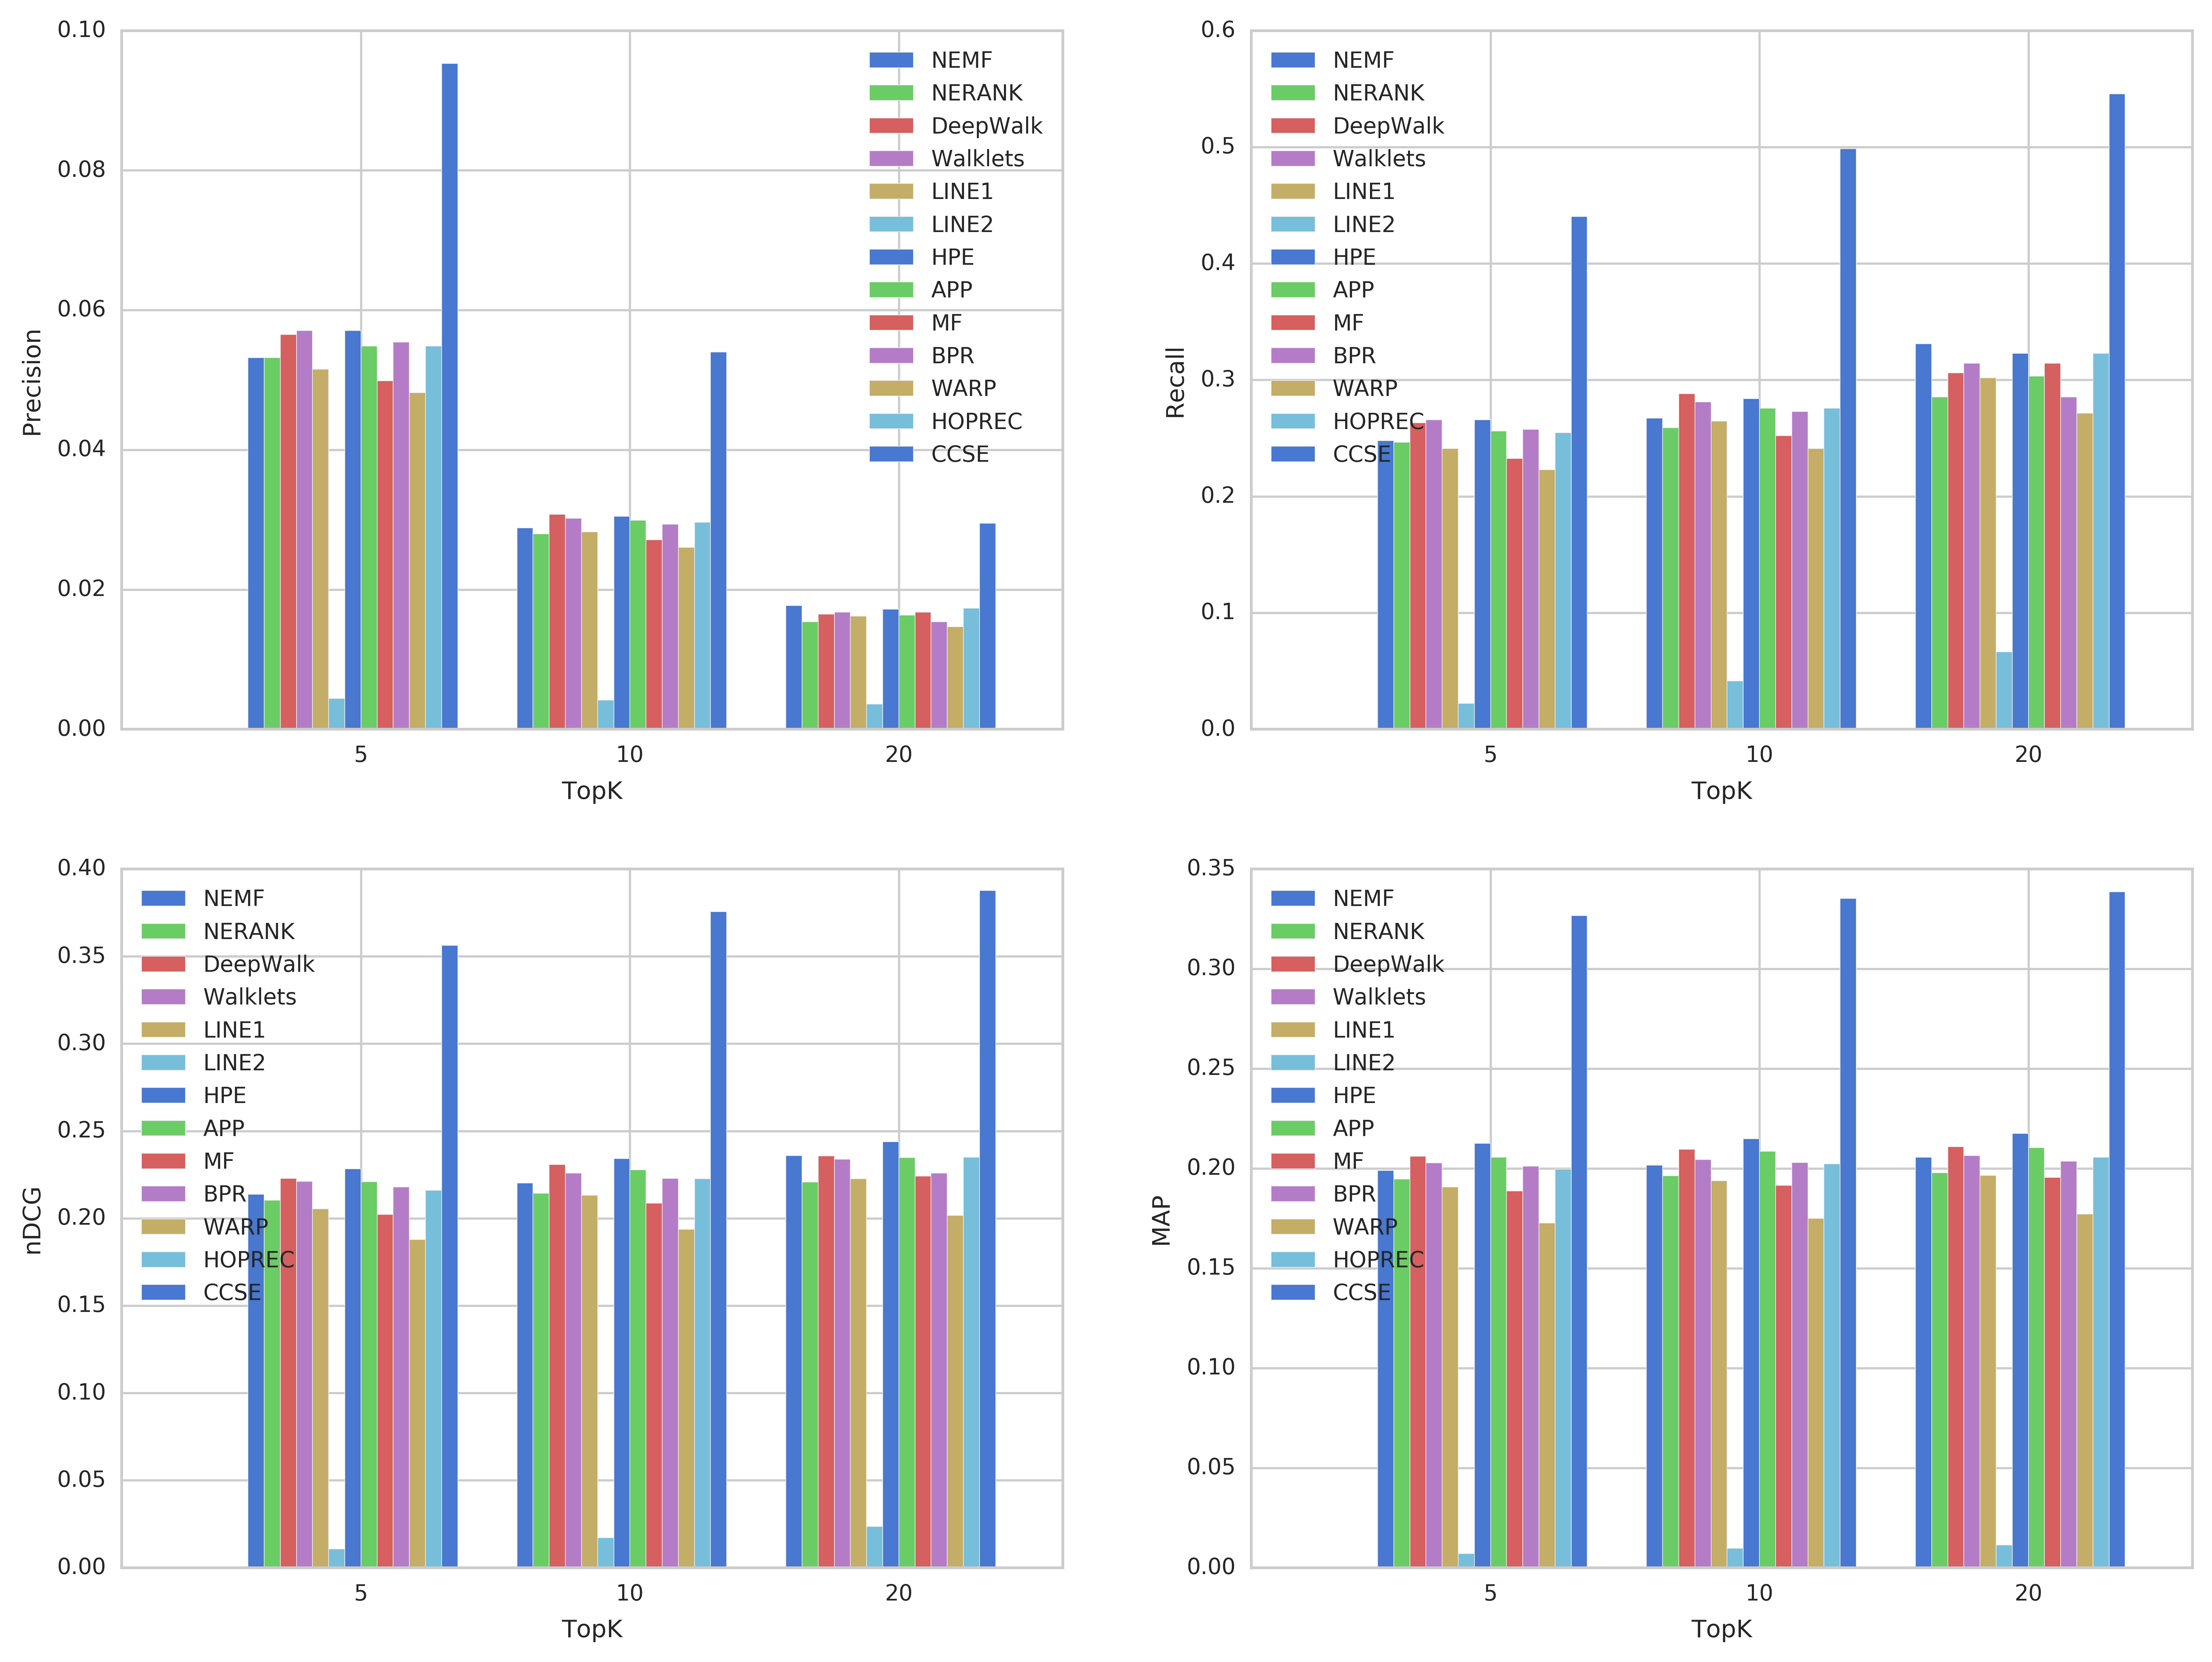

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# fig, ax = plt.subplots(1, 3)
fig = plt.figure(figsize=[12, 10], dpi=600)
ax = fig.subplots(nrows=2, ncols=2)

# precision
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
precision_at_5s = douban_concat_dataframe.loc[:, "precision_at_5"].to_list()
precision_at_10s = douban_concat_dataframe.loc[:, "precision_at_10"].to_list()
precision_at_20s = douban_concat_dataframe.loc[:, "precision_at_20"].to_list()

positions = np.arange(3)
width = 0.06
for i, algorithm in enumerate(algorithms):
    precisions = [precision_at_5s[i], precision_at_10s[i], precision_at_20s[i]]
    ax[0, 0].bar(positions+i*width, precisions, width, label=algorithm)
ax[0, 0].set_xticks(positions+len(algorithms)*width/2)
ax[0, 0].set_xticklabels(["5", "10", "20"])
ax[0, 0].set_xlabel("TopK")
ax[0, 0].set_ylabel("Precision")
ax[0, 0].legend(loc="best")

# recall
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
recall_at_5s = douban_concat_dataframe.loc[:, "recall_at_5"].to_list()
recall_at_10s = douban_concat_dataframe.loc[:, "recall_at_10"].to_list()
recall_at_20s = douban_concat_dataframe.loc[:, "recall_at_20"].to_list()

positions = np.arange(3)
width = 0.06
for i, algorithm in enumerate(algorithms):
    recalls = [recall_at_5s[i], recall_at_10s[i], recall_at_20s[i]]
    ax[0, 1].bar(positions+i*width, recalls, width, label=algorithm)
ax[0, 1].set_xticks(positions+len(algorithms)*width/2)
ax[0, 1].set_xticklabels(["5", "10", "20"])
ax[0, 1].set_xlabel("TopK")
ax[0, 1].set_ylabel("Recall")
ax[0, 1].legend(loc="best")

# ndcg
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
ndcg_at_5s = douban_concat_dataframe.loc[:, "ndcg_at_5"].to_list()
ndcg_at_10s = douban_concat_dataframe.loc[:, "ndcg_at_10"].to_list()
ndcg_at_20s = douban_concat_dataframe.loc[:, "ndcg_at_20"].to_list()

positions = np.arange(3)
width = 0.06
for i, algorithm in enumerate(algorithms):
    ndcgs = [ndcg_at_5s[i], ndcg_at_10s[i], ndcg_at_20s[i]]
    ax[1, 0].bar(positions+i*width, ndcgs, width, label=algorithm)
ax[1, 0].set_xticks(positions+len(algorithms)*width/2)
ax[1, 0].set_xticklabels(["5", "10", "20"])
ax[1, 0].set_xlabel("TopK")
ax[1, 0].set_ylabel("nDCG")
ax[1, 0].legend(loc="best")

# map
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
map_at_5s = douban_concat_dataframe.loc[:, "map_at_5"].to_list()
map_at_10s = douban_concat_dataframe.loc[:, "map_at_10"].to_list()
map_at_20s = douban_concat_dataframe.loc[:, "map_at_20"].to_list()

positions = np.arange(3)
width = 0.06
for i, algorithm in enumerate(algorithms):
    maps = [map_at_5s[i], map_at_10s[i], map_at_20s[i]]
    ax[1, 1].bar(positions+i*width, maps, width, label=algorithm)
ax[1, 1].set_xticks(positions+len(algorithms)*width/2)
ax[1, 1].set_xticklabels(["5", "10", "20"])
ax[1, 1].set_xlabel("TopK")
ax[1, 1].set_ylabel("MAP")
ax[1, 1].legend(loc="best")

fig.savefig('./images/evaluations.eps', dpi=600, format="eps")
fig.savefig("./images/evaluations.png", dpi=600, format="png")